In [ ]:
!unzip data.zip

In [102]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets

from sklearn.metrics import classification_report, confusion_matrix

In [103]:
# ## 2. Configuration and Paths
class Config:
    TRAIN_PATH = "/content/hand_gesture/train/train"
    TEST_PATH = "/content/hand_gesture/test/test"

    # Image processing
    IMAGE_SIZE = (224, 224)

    # Model & Training
    BATCH_SIZE = 30
    EPOCHS = 1
    LEARNING_RATE = 0.001
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Dataset loaded successfully. Found 18000 images in 20 classes.
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


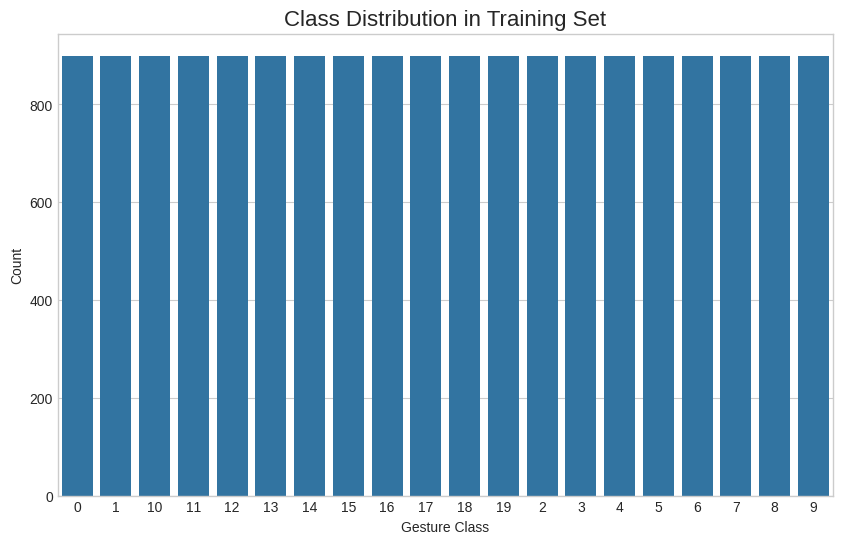

In [104]:
# ## 3. Data Loading using ImageFolder and EDA
try:
    if not os.path.exists(Config.TRAIN_PATH) or not os.path.exists(Config.TEST_PATH):
        raise FileNotFoundError

    # torchvision.datasets.ImageFolder를 사용하여 데이터 로드
    # ImageFolder는 폴더 이름을 자동으로 클래스 레이블로 사용합니다.
    temp_dataset = datasets.ImageFolder(root=Config.TRAIN_PATH)
    class_names = temp_dataset.classes
    print(f"Dataset loaded successfully. Found {len(temp_dataset)} images in {len(class_names)} classes.")
    print(f"Class names: {class_names}")

    # EDA: 훈련 데이터셋 클래스 분포 확인
    class_counts = {cls: count for cls, count in zip(temp_dataset.classes, np.bincount(temp_dataset.targets))}
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution in Training Set', fontsize=16)
    plt.xlabel('Gesture Class')
    plt.ylabel('Count')
    plt.show()

except FileNotFoundError:
    print(f"Error: Directory '{Config.TRAIN_PATH}' or '{Config.TEST_PATH}' not found.")
    class_names = []

In [105]:
# ## 4. Data Transforms, Splitting, and DataLoaders
if class_names:
    # 이미지 변환 정의
    train_transform = transforms.Compose([
        transforms.Resize(Config.IMAGE_SIZE),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(Config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 훈련 데이터셋을 로드하고 훈련/검증용으로 분할
    full_train_dataset = datasets.ImageFolder(root=Config.TRAIN_PATH)

    val_split = 0.2
    val_size = int(val_split * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size

    train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

    # 각 subset에 맞는 transform 적용
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform

    # 테스트 데이터셋 로드
    test_dataset = datasets.ImageFolder(root=Config.TEST_PATH, transform=val_test_transform)

    # DataLoader 생성
    train_loader = DataLoader(train_subset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

    print(f"\nData ready. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")



Data ready. Train batches: 480, Val batches: 120, Test batches: 200


In [106]:
# ## 5. Model Definition (Transfer Learning)
if class_names:
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(Config.DEVICE)
    print("\n--- Using pre-trained ResNet18 model ---")


--- Using pre-trained ResNet18 model ---


In [107]:
# ## 6. Training Loop
def train_model(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * features.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_correct / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    return model, history

In [108]:
if class_names:
    print("\n--- Starting Model Training ---")
    trained_model, history = train_model(model, train_loader, val_loader, Config.EPOCHS, Config.LEARNING_RATE, Config.DEVICE)
    print("--- Training Finished ---")


--- Starting Model Training ---


Epoch 1/1 [Val]: 100%|██████████| 120/120 [00:10<00:00, 11.75it/s]

Epoch 1/1 -> Train Loss: 0.0338, Train Acc: 0.9926 | Val Loss: 0.0006, Val Acc: 1.0000
--- Training Finished ---


[Test]: 100%|██████████| 200/200 [00:19<00:00, 10.52it/s]


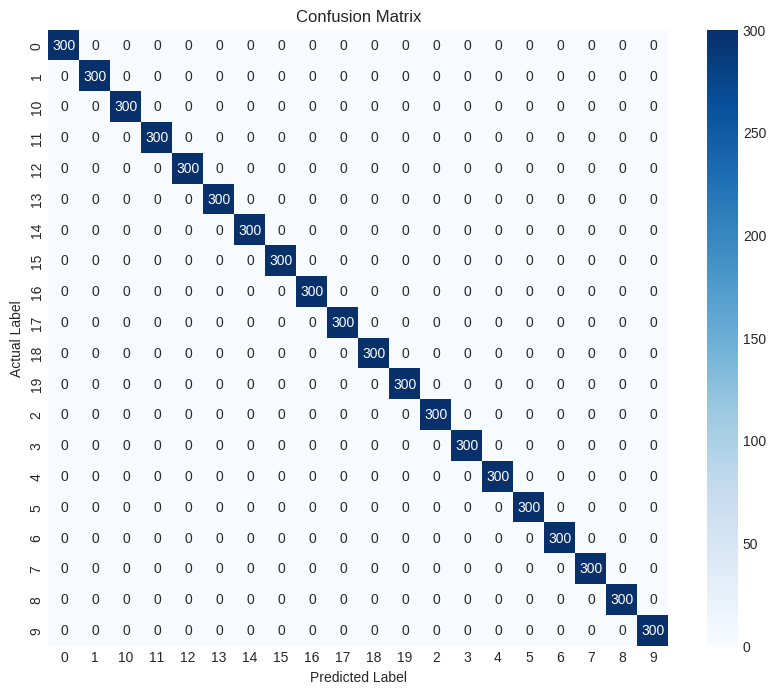


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300
          12       1.00      1.00      1.00       300
          13       1.00      1.00      1.00       300
          14       1.00      1.00      1.00       300
          15       1.00      1.00      1.00       300
          16       1.00      1.00      1.00       300
          17       1.00      1.00      1.00       300
          18       1.00      1.00      1.00       300
          19       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
    

In [110]:
# ## 7. Performance Evaluation
if class_names and 'history' in locals():
    # 최종 테스트셋 평가
    trained_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="[Test]"):
            features = features.to(Config.DEVICE)
            outputs = trained_model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print('\nClassification Report')
    print(classification_report(all_labels, all_preds, target_names=class_names))